In [ ]:
!pip install lime
!pip install pykan
!pip install catboost
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=78ca8994043efddc5fec78f6a7531bf4a2572abfff69d2fcea14e534a1c9b669
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
import xgboost as xgb
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import average_precision_score, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.inspection import permutation_importance

import lime
import lime.lime_tabular
from captum.attr import LRP


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/SalvatoreRa/tutorial/refs/heads/main/datasets/adult.csv")
col_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
             "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
             "hours_per_week", "native_country", "income"]
df.columns = col_names
categorical = ["workclass", "education", "marital_status", "occupation",
               "relationship", "race", "sex", "native_country", "income"]
df = df[~df[categorical].apply(lambda row: row.str.contains('\?', na=False)).any(axis=1)]
df = df[df.workclass != "never-worked"]
df = df[df.workclass != "without-pay"]
df = df[df.occupation != "Armed-Forces"]
df = df[df.native_country != "Holand-Netherlands"]
df["education"] = df["education"].str.replace("1st-4th", "Elementary-School")
df["education"] = df["education"].str.replace("5th-6th", "Elementary-School")
df["education"] = df["education"].str.replace("7th-8th", "Elementary-School")
df["education"] = df["education"].str.replace("9th", "High-School")
df["education"] = df["education"].str.replace("10th", "High-School")
df["education"] = df["education"].str.replace("11th", "High-School")
df["education"] = df["education"].str.replace("12th", "High-School")
df["education"] = df["education"].str.replace("Masters", "Postgraduate")
df["education"] = df["education"].str.replace("Doctorate", "Postgraduate")
df["education"] = df["education"].str.replace("Bachelors", "Undergraduate")
df["education"] = df["education"].str.replace("Some-college", "Undergraduate")

from sklearn.preprocessing import LabelEncoder

def label_encoder(column):
    le = LabelEncoder().fit(column)
    #print(column.name, le.classes_)
    return le.transform(column)

cols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "income"]
for col in cols:
    df[col] = label_encoder(df[col])


X = df.drop("income", axis=1)
y = df["income"]

In [ ]:
# XGBoost
%%capture
start_time = time.time()
measures = [ 'Accuracy', 'Micro precision', 'Micro recall', 'Micro F1 score',
        'Macro precision', 'Macro recall', 'Macro F1 score',
           'Weighted precision', 'Weighted recall', 'Weighted F1 score',
           'c_index']


n = 10
split_i = np.array(range(n) )
results = pd.DataFrame(index = split_i, columns = measures)

N_feat = np.array(range(X.shape[1]) )
feat_imp_xgboost = pd.DataFrame(index = N_feat, columns = split_i)
feat_imp_gain = pd.DataFrame(index = N_feat, columns = split_i)
feat_imp_shap = pd.DataFrame(index = N_feat, columns = split_i)
feat_imp_lime = pd.DataFrame(index = N_feat, columns = split_i)
feat_imp_perm = pd.DataFrame(index = N_feat, columns = split_i)

for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                                random_state=i, stratify = y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10,
                                                          random_state=i, stratify = y_train)
        #scaling the data
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)




        model = xgb.XGBClassifier( random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results.loc[i, "Accuracy"] = accuracy_score(y_test, y_pred)
        results.loc[i, "Micro precision"] = precision_score(y_test, y_pred, average='micro')
        results.loc[i, "Micro recall"] = recall_score(y_test, y_pred, average='micro')
        results.loc[i, "Micro F1 score"] = f1_score(y_test, y_pred, average='micro')
        results.loc[i, "Macro precision"] = precision_score(y_test, y_pred, average='macro')
        results.loc[i, "Macro recall"] = recall_score(y_test, y_pred, average='macro')
        results.loc[i, "Macro F1 score"] = f1_score(y_test, y_pred, average='macro')
        results.loc[i, "Weighted precision"] = precision_score(y_test, y_pred, average='weighted')
        results.loc[i, "Weighted recall"] = recall_score(y_test, y_pred, average='weighted')
        results.loc[i, "Weighted F1 score"] = f1_score(y_test, y_pred, average='weighted')
        feat_imp_xgboost.loc[:,i] = model.feature_importances_

        imp = model.get_booster().get_score(importance_type= 'gain')
        imp = {key: value for key, value in sorted(imp.items())}
        feat_imp_gain.loc[:,i] = list(imp.values())

        explainer=shap.Explainer(model)
        shap_values = explainer(pd.DataFrame(X_test, columns =X.columns))
        shap_values.shape, X.shape
        shap_values.values.shape, X_test.shape
        vals = np.abs(shap_values.values).mean(0)
        shap_importance = pd.DataFrame(list(zip(X.columns.to_list(), vals)),
                                       columns=['col_name', 'feature_importance_vals'])
        sh =shap_importance.feature_importance_vals.to_list()
        feat_imp_shap.loc[:,i] = sh


        explainer = lime.lime_tabular.LimeTabularExplainer(X_test,
                                                   feature_names=X.columns.to_list(),
                                                   class_names=['0','1'],
                                                   discretize_continuous=False)

        # create array with predicted signal probabilities
        proba_signal = model.predict_proba(X_test)[:,1]
        importances = { i: 0.0 for i in range(X_test.shape[1]) }
        # number of instances to generate explanations for
        num_explain = 1000
        for i in range(num_explain):
            # collect feature importances for the signal class only
            if proba_signal[i] > 0.5:
                exp = explainer.explain_instance(X_test[i],
                                                 model.predict_proba,
                                                 num_features=X.shape[1])
                exp_map = exp.as_map()
                # get all feature labels of class "1"
                feat = [exp_map[1][m][0] for m in range(len(exp_map[1]))]
                # get all feature weights of class "1"
                weight = [exp_map[1][m][1] for m in range(len(exp_map[1]))]
                # sum the weights, for each feature individually
                for m in range(len(feat)):
                    importances[feat[m]] = importances[feat[m]] + weight[m]
        # normalize the distribution (probably meaningless...)
        for i in range(X.shape[1]):
            importances[i] = importances[i] / (num_explain*1.0)
        feat_imp_lime.loc[:,i] = list(importances.values())


        perm = permutation_importance(model, X_test, y_test)
        perm =perm.importances_mean
        feat_imp_perm.loc[:,i] = perm


In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))


--- 254.18698930740356 seconds ---


In [ ]:
%%capture
start_time = time.time()
measures = [ 'Accuracy', 'Micro precision', 'Micro recall', 'Micro F1 score',
        'Macro precision', 'Macro recall', 'Macro F1 score',
           'Weighted precision', 'Weighted recall', 'Weighted F1 score',
           'c_index']


n = 10
split_i = np.array(range(n) )
results_lr = pd.DataFrame(index = split_i, columns = measures)

N_feat = np.array(range(X.shape[1]) )

logi_imp = pd.DataFrame(index = N_feat, columns = split_i)

for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                                random_state=i, stratify = y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10,
                                                          random_state=i, stratify = y_train)
        #scaling the data
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)


            #y_val[:5], y_val_enc[:5], y_train[:5],  y_train_enc[:5]

        model = LogisticRegression( random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results_lr.loc[i, "Accuracy"] = accuracy_score(y_test, y_pred)
        results_lr.loc[i, "Micro precision"] = precision_score(y_test, y_pred, average='micro')
        results_lr.loc[i, "Micro recall"] = recall_score(y_test, y_pred, average='micro')
        results_lr.loc[i, "Micro F1 score"] = f1_score(y_test, y_pred, average='micro')
        results_lr.loc[i, "Macro precision"] = precision_score(y_test, y_pred, average='macro')
        results_lr.loc[i, "Macro recall"] = recall_score(y_test, y_pred, average='macro')
        results_lr.loc[i, "Macro F1 score"] = f1_score(y_test, y_pred, average='macro')
        results_lr.loc[i, "Weighted precision"] = precision_score(y_test, y_pred, average='weighted')
        results_lr.loc[i, "Weighted recall"] = recall_score(y_test, y_pred, average='weighted')
        results_lr.loc[i, "Weighted F1 score"] = f1_score(y_test, y_pred, average='weighted')
        logi_imp.loc[:,i] = np.abs(model.coef_)[0]

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))


--- 3.9434754848480225 seconds ---


In [ ]:
from catboost import CatBoostClassifier
start_time = time.time()

measures = [ 'Accuracy', 'Micro precision', 'Micro recall', 'Micro F1 score',
             'Macro precision', 'Macro recall', 'Macro F1 score',
             'Weighted precision', 'Weighted recall', 'Weighted F1 score']

n = 10
split_i = np.array(range(n))
results_cb = pd.DataFrame(index=split_i, columns=measures)

N_feat = np.array(range(X.shape[1]))
catboost_imp = pd.DataFrame(index=N_feat, columns=split_i)

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                         random_state=i, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10,
                                                      random_state=i, stratify=y_train)
    # Scaling the data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Initialize and train CatBoostClassifier
    model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=0, random_seed=i)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_test)

    results_cb.loc[i, "Accuracy"] = accuracy_score(y_test, y_pred)
    results_cb.loc[i, "Micro precision"] = precision_score(y_test, y_pred, average='micro')
    results_cb.loc[i, "Micro recall"] = recall_score(y_test, y_pred, average='micro')
    results_cb.loc[i, "Micro F1 score"] = f1_score(y_test, y_pred, average='micro')
    results_cb.loc[i, "Macro precision"] = precision_score(y_test, y_pred, average='macro')
    results_cb.loc[i, "Macro recall"] = recall_score(y_test, y_pred, average='macro')
    results_cb.loc[i, "Macro F1 score"] = f1_score(y_test, y_pred, average='macro')
    results_cb.loc[i, "Weighted precision"] = precision_score(y_test, y_pred, average='weighted')
    results_cb.loc[i, "Weighted recall"] = recall_score(y_test, y_pred, average='weighted')
    results_cb.loc[i, "Weighted F1 score"] = f1_score(y_test, y_pred, average='weighted')

    catboost_imp.loc[:, i] = model.get_feature_importance()

print("--- %s seconds ---" % (time.time() - start_time))


--- 63.42940282821655 seconds ---


In [ ]:
%%capture

from lightgbm import LGBMClassifier
# Start timing
start_time = time.time()

measures = [ 'Accuracy', 'Micro precision', 'Micro recall', 'Micro F1 score',
             'Macro precision', 'Macro recall', 'Macro F1 score',
             'Weighted precision', 'Weighted recall', 'Weighted F1 score']

n = 10
split_i = np.array(range(n))
results_lgbm = pd.DataFrame(index=split_i, columns=measures)

N_feat = np.array(range(X.shape[1]))
lgbm_imp = pd.DataFrame(index=N_feat, columns=split_i)

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                         random_state=i, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10,
                                                      random_state=i, stratify=y_train)
    # Scaling the data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Initialize and train LGBMClassifier
    model = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=i)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)

    results_lgbm.loc[i, "Accuracy"] = accuracy_score(y_test, y_pred)
    results_lgbm.loc[i, "Micro precision"] = precision_score(y_test, y_pred, average='micro')
    results_lgbm.loc[i, "Micro recall"] = recall_score(y_test, y_pred, average='micro')
    results_lgbm.loc[i, "Micro F1 score"] = f1_score(y_test, y_pred, average='micro')
    results_lgbm.loc[i, "Macro precision"] = precision_score(y_test, y_pred, average='macro')
    results_lgbm.loc[i, "Macro recall"] = recall_score(y_test, y_pred, average='macro')
    results_lgbm.loc[i, "Macro F1 score"] = f1_score(y_test, y_pred, average='macro')
    results_lgbm.loc[i, "Weighted precision"] = precision_score(y_test, y_pred, average='weighted')
    results_lgbm.loc[i, "Weighted recall"] = recall_score(y_test, y_pred, average='weighted')
    results_lgbm.loc[i, "Weighted F1 score"] = f1_score(y_test, y_pred, average='weighted')

    lgbm_imp.loc[:, i] = model.feature_importances_
print("--- %s seconds ---" % (time.time() - start_time))
results_lgbm

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from captum.attr import LRP, DeepLift, DeepLiftShap, GradientShap

# Define Feed-Forward Neural Network
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=1):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Start timing
start_time = time.time()

measures = [ 'Accuracy', 'Micro precision', 'Micro recall', 'Micro F1 score',
             'Macro precision', 'Macro recall', 'Macro F1 score',
             'Weighted precision', 'Weighted recall', 'Weighted F1 score']

n = 10
batch_size = 1000
sample_size = 200  # Reduce number of samples for DeepLiftShap and GradientShap
split_i = np.array(range(n))
results_nn = pd.DataFrame(index=split_i, columns=measures)
feature_importance_LRP = pd.DataFrame(index=N_feat, columns=split_i)
feature_importance_DeepLift = pd.DataFrame(index=N_feat, columns=split_i)
feature_importance_DeepLiftShap = pd.DataFrame(index=N_feat, columns=split_i)
feature_importance_GradientShap = pd.DataFrame(index=N_feat, columns=split_i)

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                         random_state=i, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10,
                                                      random_state=i, stratify=y_train)
    # Scaling the data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, requires_grad=True)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define model, loss function, and optimizer
    model = FeedForwardNN(input_size=X.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate on test set
    with torch.no_grad():
        y_pred = torch.sigmoid(model(X_test_tensor))
        y_pred = (y_pred.numpy() > 0.5).astype(int)

    results_nn.loc[i, "Accuracy"] = accuracy_score(y_test, y_pred)
    results_nn.loc[i, "Micro precision"] = precision_score(y_test, y_pred, average='micro')
    results_nn.loc[i, "Micro recall"] = recall_score(y_test, y_pred, average='micro')
    results_nn.loc[i, "Micro F1 score"] = f1_score(y_test, y_pred, average='micro')
    results_nn.loc[i, "Macro precision"] = precision_score(y_test, y_pred, average='macro')
    results_nn.loc[i, "Macro recall"] = recall_score(y_test, y_pred, average='macro')
    results_nn.loc[i, "Macro F1 score"] = f1_score(y_test, y_pred, average='macro')
    results_nn.loc[i, "Weighted precision"] = precision_score(y_test, y_pred, average='weighted')
    results_nn.loc[i, "Weighted recall"] = recall_score(y_test, y_pred, average='weighted')
    results_nn.loc[i, "Weighted F1 score"] = f1_score(y_test, y_pred, average='weighted')

    # Compute feature importance using LRP
    lrp = LRP(model)
    attributions_lrp = lrp.attribute(X_test_tensor)
    attributions_lrp = attributions_lrp.abs().mean(dim=0).detach().numpy()
    feature_importance_LRP.loc[:, i] = attributions_lrp

    # Compute feature importance using DeepLift
    deep_lift = DeepLift(model)
    attributions_dl = deep_lift.attribute(X_test_tensor)
    attributions_dl = attributions_dl.abs().mean(dim=0).detach().numpy()
    feature_importance_DeepLift.loc[:, i] = attributions_dl

    # Compute feature importance using DeepLiftShap (reduced sample size)
    deep_lift_shap = DeepLiftShap(model)
    attributions_dls = deep_lift_shap.attribute(X_test_tensor[:sample_size], baselines=X_train_tensor[:sample_size])
    attributions_dls = attributions_dls.abs().mean(dim=0).detach().numpy()
    feature_importance_DeepLiftShap.loc[:, i] = attributions_dls

    # Compute feature importance using GradientShap (reduced sample size)
    gradient_shap = GradientShap(model)
    baselines = X_train_tensor[torch.randint(0, X_train_tensor.shape[0], (sample_size,))]
    attributions_gs = gradient_shap.attribute(X_test_tensor[:sample_size], baselines=baselines)
    attributions_gs = attributions_gs.abs().mean(dim=0).detach().numpy()
    feature_importance_GradientShap.loc[:, i] = attributions_gs




/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
    

In [ ]:
%%capture
from kan import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize feature importance storage
n_splits = 10
feature_importance_kan = pd.DataFrame(index=N_feat, columns=split_i)

for i in range(n_splits):
    # Prepare dataset
    y_array = y.iloc[:1000]
    y_array = np.vstack([y_array == 0, y_array == 1]).T.astype(int)
    train_input, test_input, train_label, test_label = train_test_split(
        np.array(X.iloc[:1000, :]), y_array, test_size=0.20, random_state=i, stratify=y_array
    )

    dataset = {
        'train_input': torch.tensor(train_input, dtype=torch.float32, device=device),
        'test_input': torch.tensor(test_input, dtype=torch.float32, device=device),
        'train_label': torch.tensor(train_label, dtype=torch.float32, device=device),
        'test_label': torch.tensor(test_label, dtype=torch.float32, device=device)
    }

    # Initialize model
    model = KAN(width=[14, 8, 2], grid=5, k=3, device=device)

    # Define accuracy metrics
    def train_acc():
        return torch.mean((torch.round(model(dataset['train_input'])[:, 0]) == dataset['train_label'][:, 0]).float())

    def test_acc():
        return torch.mean((torch.round(model(dataset['test_input'])[:, 0]) == dataset['test_label'][:, 0]).float())

    # Train model
    model.fit(dataset, opt="LBFGS", steps=20, lamb=0.01, metrics=(train_acc, test_acc))

    # Store feature importance
    feature_importance_kan.loc[:, i] =model.feature_score.cpu().detach().numpy()

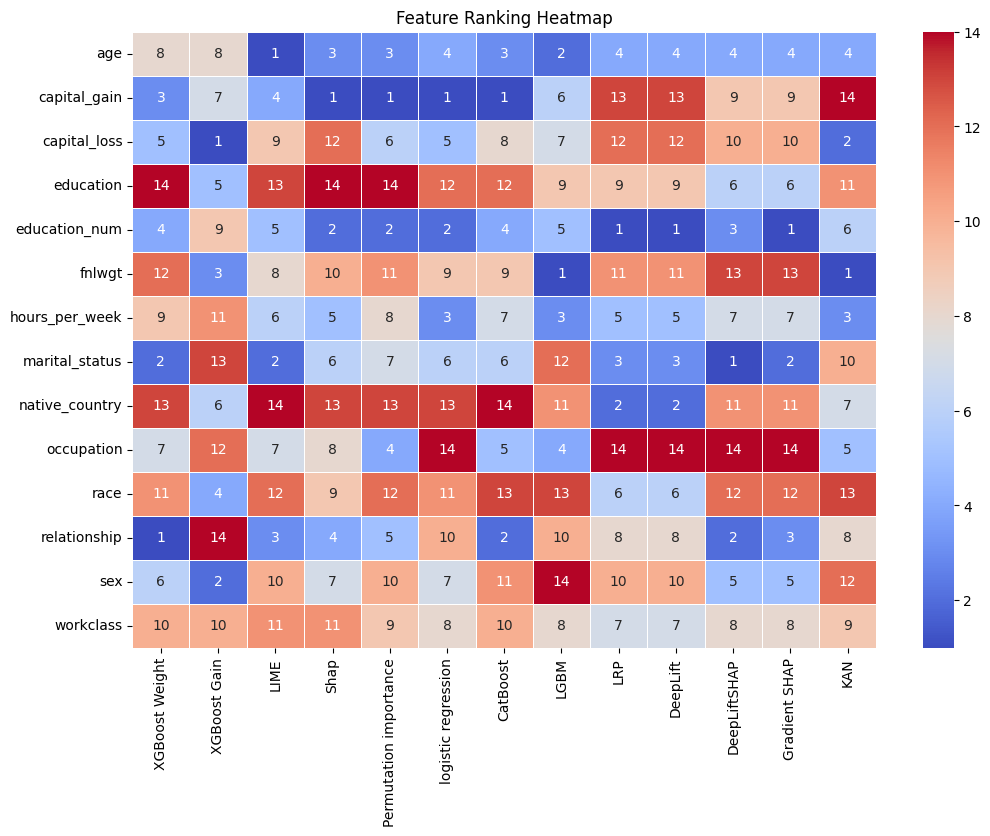

In [ ]:
ranked = pd.DataFrame()
ranked.index = X.columns.to_list()
exp_mod = ["XGBoost Weight", "XGBoost Gain",  "LIME", "Shap", "Permutation importance", "logistic regression",
           'CatBoost', 'LGBM', 'LRP','DeepLift','DeepLiftSHAP','Gradient SHAP','KAN']
files = [feat_imp_xgboost, feat_imp_gain, feat_imp_shap, feat_imp_lime, feat_imp_perm, logi_imp,
         catboost_imp, lgbm_imp, feature_importance_LRP, feature_importance_DeepLift, feature_importance_DeepLiftShap, feature_importance_GradientShap, feature_importance_kan]
ranked = ranked.sort_index()
for i in range(len(exp_mod)):
    x =files[i]
    x.index = X.columns.to_list()
    x = np.abs(x)
    x["avg"] = x.mean(axis= 1)
    x = x.sort_values(by = ["avg"], ascending= False)
    x["rank"]= [i for i in range(1,x.shape[0]+1)]
    x = x.sort_index()
    ranked[exp_mod[i]] =  x["rank"]
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the 'ranked' DataFrame already loaded

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ranked, annot=True, cmap='coolwarm', fmt='g', cbar=True, linewidths=0.5)

# Show the plot
plt.title('Feature Ranking Heatmap')
plt.show()


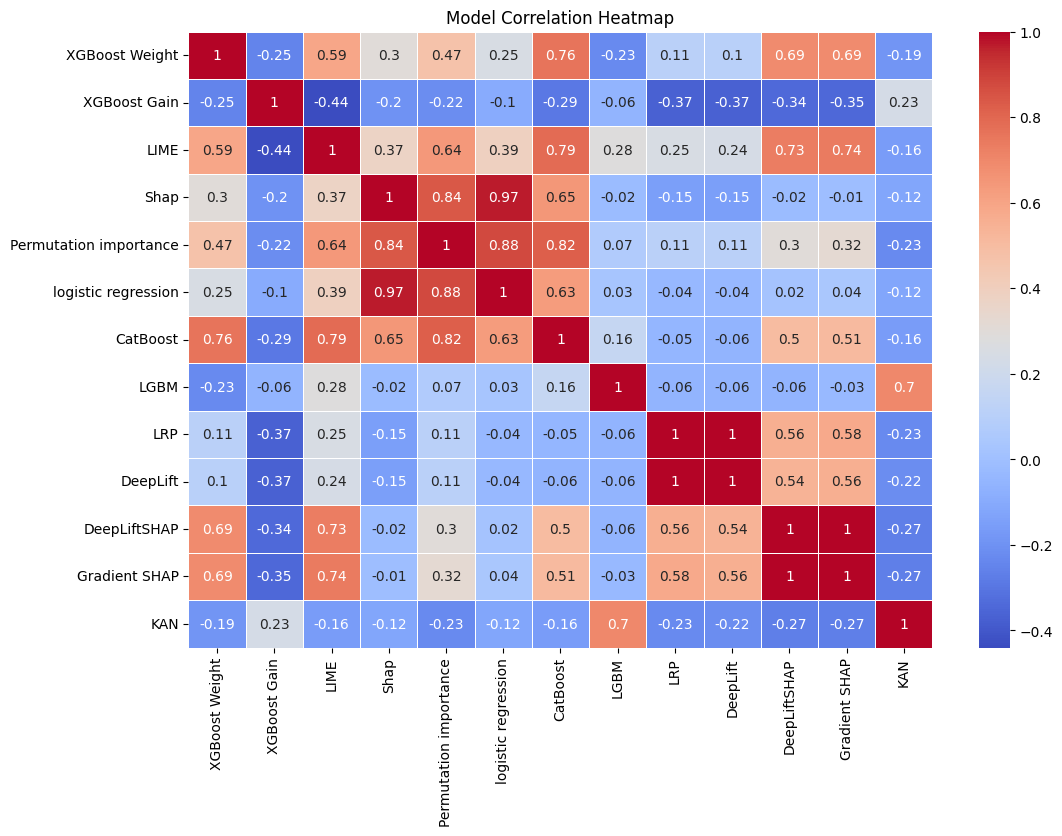

In [ ]:
corr = pd.DataFrame()
corr.index = X.columns.to_list()
exp_mod = ["XGBoost Weight", "XGBoost Gain",  "LIME", "Shap", "Permutation importance", "logistic regression",
           'CatBoost', 'LGBM', 'LRP','DeepLift','DeepLiftSHAP','Gradient SHAP','KAN']
files = [feat_imp_xgboost, feat_imp_gain, feat_imp_shap, feat_imp_lime, feat_imp_perm, logi_imp,
         catboost_imp, lgbm_imp, feature_importance_LRP, feature_importance_DeepLift, feature_importance_DeepLiftShap, feature_importance_GradientShap, feature_importance_kan]
for i in range(len(exp_mod)):
    x =files[i]
    x.index = X.columns.to_list()
    x = np.abs(x)
    x["avg"] = x.mean(axis= 1)
    corr[exp_mod[i]] =  x["avg"]
corr = corr.corr()
corr = np.round(corr, 2)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='g', cbar=True, linewidths=0.5)

# Show the plot
plt.title('Model Correlation Heatmap')
plt.show()

## Oversampling

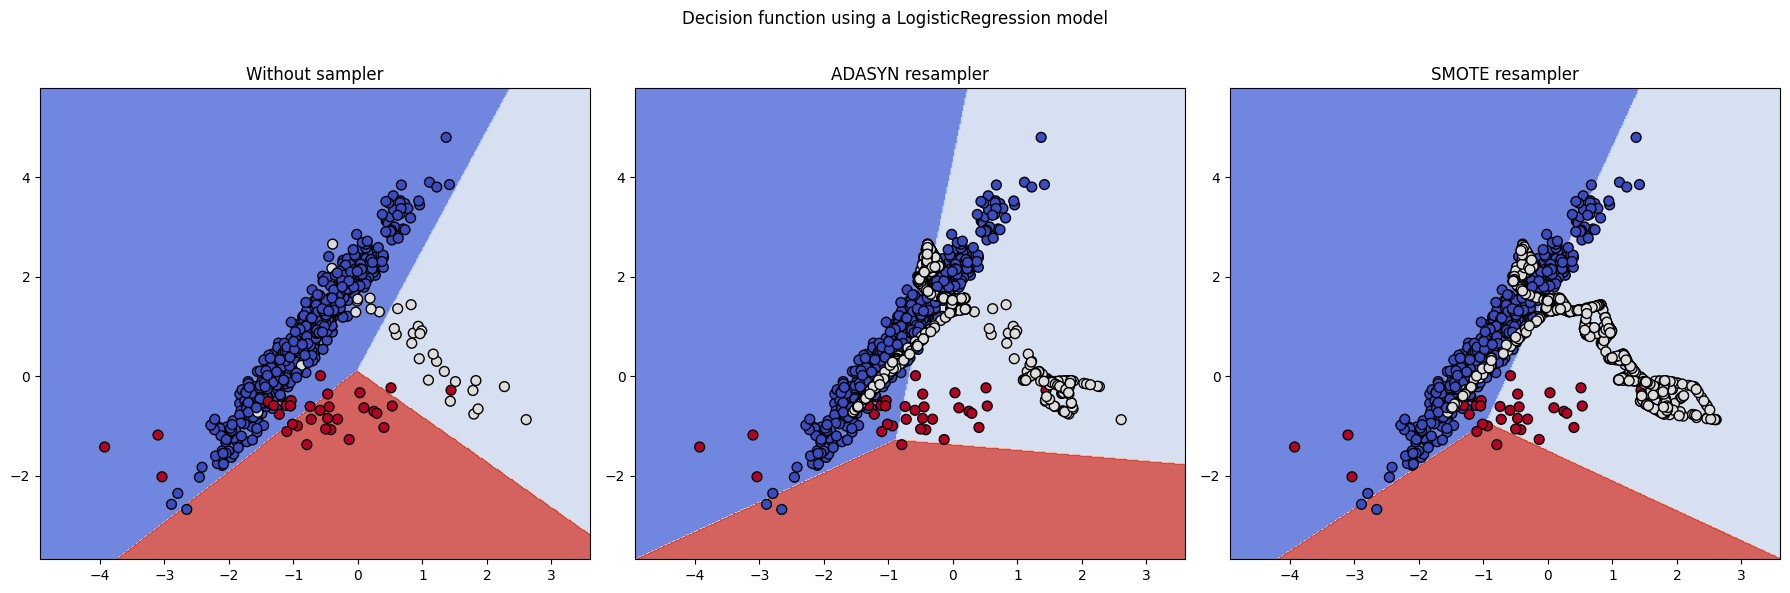

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.preprocessing import StandardScaler

# Create a dataset with three classes
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1,
                           n_classes=3, class_sep=.8, weights=[0.9, 0.05, 0.05], random_state=42)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test

# Define function to plot decision boundary
def plot_decision_boundary(X, y, model, ax, title):
    h = .02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k', cmap=plt.cm.coolwarm)
    ax.set_title(title)
    return scatter

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Decision function using a LogisticRegression model")

# Without sampler
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
plot_decision_boundary(X_train_scaled, y_train, model, axes[0], "Without sampler")

# ADASYN sampler (adjusted n_neighbors and sampling_strategy)
adasyn = ADASYN(random_state=42, n_neighbors=3, sampling_strategy='minority')  # Only resample minority classes
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
model.fit(X_resampled_adasyn, y_resampled_adasyn)
plot_decision_boundary(X_resampled_adasyn, y_resampled_adasyn, model, axes[1], "ADASYN resampler")

# SMOTE sampler (adjusted k_neighbors and sampling_strategy)
smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy='minority')  # Only resample minority classes
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train_scaled, y_train)
model.fit(X_resampled_smote, y_resampled_smote)
plot_decision_boundary(X_resampled_smote, y_resampled_smote, model, axes[2], "SMOTE resampler")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
